# Wine Classification Problem

We have a wine dataset with information about  chemical ingredients, ph, and a quality score from 0 to 10.
We want to classify a wine as good or bad, the idea is that good wines are scored 7 or above, all the rest are bad wines.




In [40]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline 


## Get Data

Data has been uploaded to an Azure ML DataStore, and the code below gets the tabular data in a pandas dataframe. If you want to use the same data go to Kaggle check it here
https://www.kaggle.com/yasserh/wine-quality-dataset


In [41]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset 

subscription_id = 'subid'
resource_group = 'resourcegroupname'
workspace_name = 'mlplayground'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='WineDataset')
df = dataset.to_pandas_dataframe()
df.head(10)

len(df)

1599

## Handling missing data

Drop rows with any having null data, the initial df had 1599 rows, after droping nulls, 1593 rows.

In [42]:
df.dropna(how='any', inplace=True)
df.isnull().sum() #verify there are no nulls or na afterwards


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Normalize Data
Machine learning algorithms tend to perform better or converge faster when the different features (variables) are on a smaller scale. 
Therefore it is common practice to normalize the data before training machine learning models on it.
Normalization also makes the training process less sensitive to the scale of the features. This results in getting better coefficients after training.


In [43]:

d = MinMaxScaler().fit_transform(df)
scaled_df = pd.DataFrame(d, columns=df.columns)


We will assume that any wine with score equal or above 7 is Good and below 7 is bad.   Good Wines will be labeled as 1, Bad Wines as 0 on a new column QualityLabel

In [44]:
scaled_df['QualityLabel'] = np.where(scaled_df['quality']>=0.7,1,0)

# Count unique values for the quality score.
scaled_df['quality'].value_counts()

0.4    679
0.6    636
0.8    197
0.2     53
1.0     18
0.0     10
Name: quality, dtype: int64

In [45]:
# Tuple of  # of rows and # of columns in DataFrame
# SO we have 1599 rows and 12 columns
scaled_df.shape

(1593, 13)

In [46]:
# Basic descriptive and statistics for each column
scaled_df.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,QualityLabel
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,0.329611,0.279472,0.270778,0.111655,0.125914,0.208376,0.260103,0.490934,0.450089,0.196812,0.310913,0.526930,0.134965
std,0.154158,0.122536,0.194351,0.095618,0.078414,0.145851,0.205892,0.138101,0.121444,0.101538,0.163761,0.161445,0.341794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221239,0.184932,0.090000,0.068493,0.096828,0.084507,0.103896,0.406021,0.370079,0.131737,0.169231,0.400000,0.000000
50%,0.292035,0.273973,0.260000,0.089041,0.111853,0.183099,0.207792,0.490455,0.448819,0.173653,0.276923,0.600000,0.000000
75%,0.407080,0.356164,0.420000,0.116438,0.130217,0.281690,0.363636,0.571219,0.519685,0.239521,0.415385,0.600000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Plotting Distributions

Its important to plot the value distribution to understand the data.
As you can see for quality, most of the wines are between 5 and 6.  Not many  too low or too high scored wines in the sample data.
Here I am using the original dataframe and not the scaled dataframe to make it easier to understand.

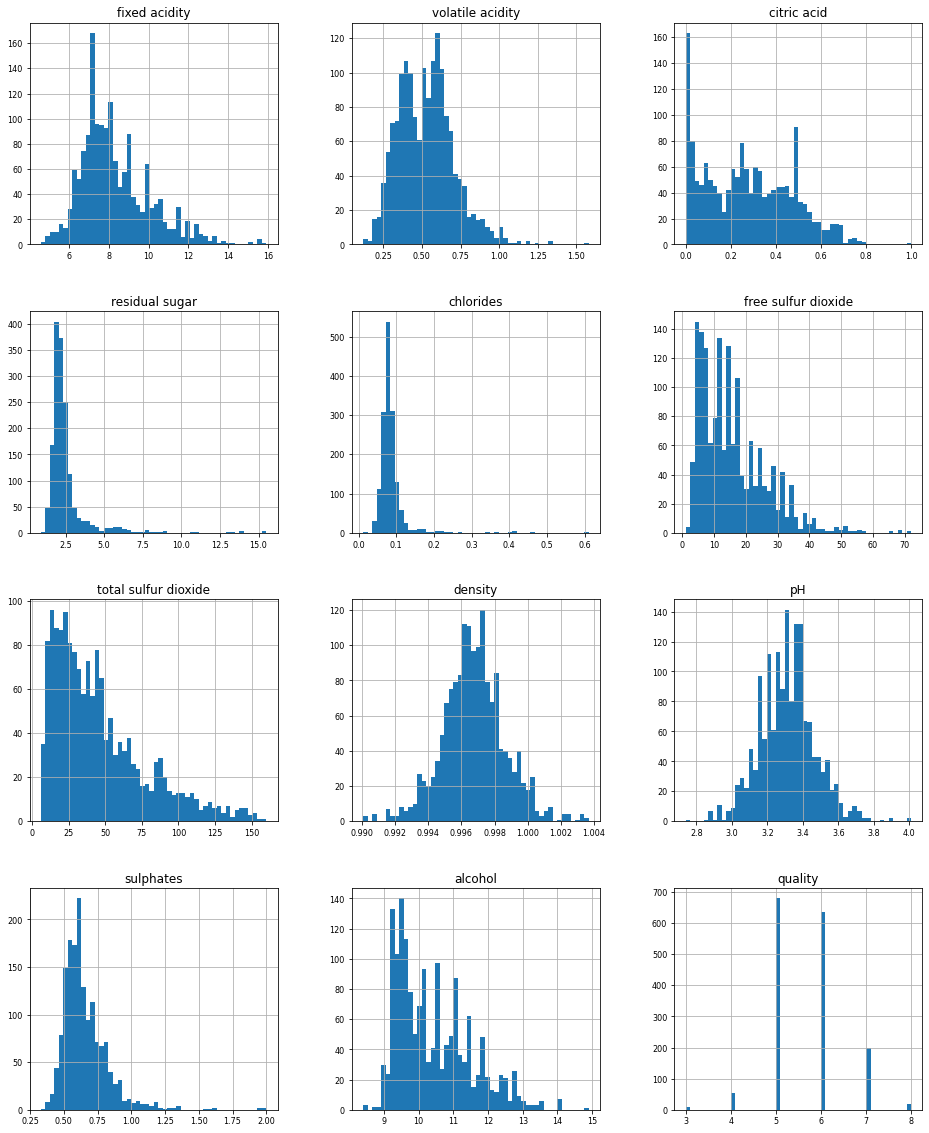

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# listing dataframes types
list(set(df.dtypes.tolist()))
# include only float and integer
df_num = df.select_dtypes(include = ['float64', 'int64'])
# display what has been selected
df_num.head()
# plot
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

We need to check if the dataset is balanced for the label we want to predict


In [48]:
# We can use value counts
scaled_df['QualityLabel'].value_counts()

# or we can separate the classes and then print the shape 
class_0 = scaled_df[scaled_df['QualityLabel'] == 0]
class_1 = scaled_df[scaled_df['QualityLabel'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)


class 0: (1378, 13)
class 1: (215, 13)


I like to visually see the imbalance, so we plot each class and its frequency and see the difference in the bars, we need to do something about it.

0    1378
1     215
Name: QualityLabel, dtype: int64

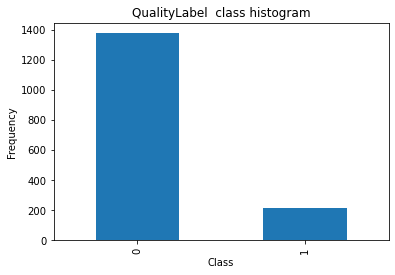

In [49]:
import matplotlib.pyplot as plt
scaled_df.value_counts(scaled_df['QualityLabel']).plot.bar()
plt.title('QualityLabel  class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
scaled_df['QualityLabel'].value_counts()

## Split Test Train

First we need to split data for training and testing purposes

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(['QualityLabel','quality'],axis=1), scaled_df["QualityLabel"], test_size=0.3, random_state=0)

## Lets try a logistic classifier

[[406  12]
 [ 44  16]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       418
           1       0.57      0.27      0.36        60

    accuracy                           0.88       478
   macro avg       0.74      0.62      0.65       478
weighted avg       0.86      0.88      0.86       478

Accuracy = 0.88
Recall = 0.27



Text(0.5, 1.0, 'Confusion Matrix (without SMOTE)')

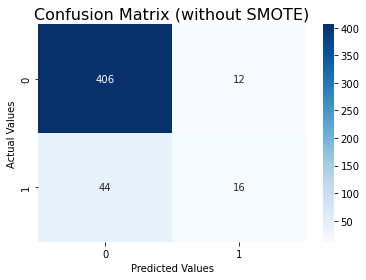

In [51]:
from sklearn.linear_model import LogisticRegression
#Initalize the classifier
clf = LogisticRegression(random_state=0)
#Fitting the training data
clf.fit(X_train, y_train)
#Predicting on test
y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')
cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix (without SMOTE)', size=16)




**There are four ways to check if the predictions are right or wrong:**
- TN / True Negative: the case was negative and predicted negative
- TP / True Positive: the case was positive and predicted positive
- FN / False Negative: the case was positive but predicted negative
- FP / False Positive: the case was negative but predicted positive

**Precision — What percent of your predictions were correct?**

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.

**Precision:**- Accuracy of positive predictions.
Precision = TP/(TP + FP)

**Recall — What percent of the positive cases did you catch?**

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

**F1 score — What percent of positive predictions were correct?**

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

**Support**

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

# Lets resample with SMOTE



The dataframe is really unbalanced, too many  bad wines compared to the good wines, lets balance it.

![image-alt-text](https://miro.medium.com/max/630/1*6DlvkNY2TlFw2Veyvb4qdQ.jpeg)

We can either oversample the good label, or undersample the bad label.  For this project lets do oversampling.

In [52]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(scaled_df,  scaled_df["QualityLabel"])

# we split again, (the resampled dataset)
X_train, X_test, y_train, y_test = train_test_split(X_sm.drop(['QualityLabel','quality'],axis=1), y_sm, test_size=0.3, random_state=0)

print(f'''Shape of X before SMOTE: {scaled_df.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1593, 13)
Shape of X after SMOTE: (2756, 13)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: QualityLabel, dtype: float64

Oversampling added rows and now the number of rows for Class 0(Bad Wine) and Class 1(Good Wine) are the same.
Lets try the same Logistic Regression Classifier with the oversampled data.

[[327 103]
 [ 51 346]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       430
           1       0.77      0.87      0.82       397

    accuracy                           0.81       827
   macro avg       0.82      0.82      0.81       827
weighted avg       0.82      0.81      0.81       827

Accuracy = 0.81
Recall = 0.87



Text(0.5, 1.0, 'Confusion Matrix (with SMOTE)')

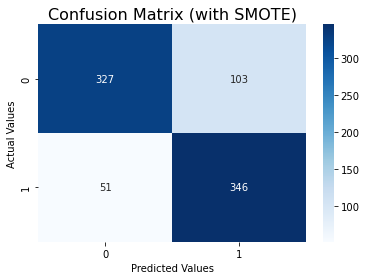

In [53]:
from sklearn.linear_model import LogisticRegression
#Initalize the classifier
clf = LogisticRegression(random_state=0)
#Fitting the training data
clf.fit(X_train, y_train)
#Predicting on test
y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')
cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix (with SMOTE)', size=16)




**Interpreation of results**

As  you can see the results are really different compared to the first classifier.  Support for example in the first dataset really shows its unbalalanced, in the second classifier the values for support are almost the same because we oversampled with SMOTE.

Accuracy went down from 0.88 to 0.81 after the resampling.

Recall went up from 0.27  to 0.87, remember the definition?
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.